# Running a circuit: CompilerBase, DensityMatrixCompiler, and (coming soon) StabilizerCompiler

## Overview [Public API]

Our compilers take as input a circuit, and produce as an output a `QuantumState` object (with some internal representation, which depends on the compiler choice). Essentially, they simulate the circuit.

Different compilers use different state representations—in the future, certain compilers may use multiple representations at once. Our current compilers are:
1. The `DensityMatrixCompiler` (fully implemented)
2. The `StabilizerCompiler` (in final debugging stages)

Both these compilers are instances of `CompilerBase` (a parent class which unites common functionality—as of August 11, 2022 the parent class in `main` is quite empty, but it will gain a lot of functionality with the merging of the `deterministic_solver_li_et_al` branch).

## Using a Compiler [Public API]


**Relevant python files:** src/backends/density_matrix/compiler.py, src/backends/stabilizer/compiler.py, src/backends/compiler_base.py

The compilers are quite simple to use. We will go over:
1. Initialization
2. Compilation
3. Compiler settings: `measurement_determinism`, `noise_simulation`

We will use the `DensityMatrixCompiler` for our examples, since it is fully developed. However, this API should be common to all compilers.

In [1]:
""" Initializing a DensityMatrix compiler """
from src.backends.density_matrix.compiler import DensityMatrixCompiler

compiler = DensityMatrixCompiler()  # no argument necessary

**NOTE:** the actual compilation is very simple. However, we must also (to obtain expected results on the circuit below) trace out the emitter qubit (which is useful to entangling the photonic qubits, but is not meant to remain in our final quantum state). 

This makes the compilation process look more complicated, but no fear; in the code, the tracing out is handled by the solver.

ghz4 expected


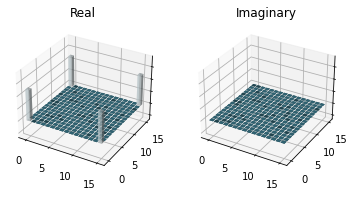

ghz4 compiled


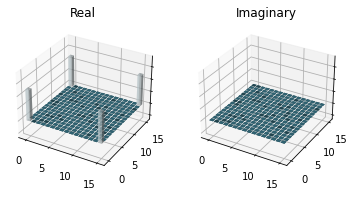

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [11]:
""" Circuit compilation """
from benchmarks.circuits import ghz4_state_circuit
from src.backends.density_matrix.state import DensityMatrix

# We can load a circuit from our benchmark set and try compiling it
ghz4_circuit, ghz4_expected = ghz4_state_circuit()
ghz4_expected = DensityMatrix(ghz4_expected['dm'])

# Compile
output_state = compiler.compile(ghz4_circuit)

# We must trace out the emitter qubit, as it is not part of our final state
# TODO: refactor to use output_state.partila_trace once the change is in
import src.backends.density_matrix.functions as dmf 

new_dm = dmf.partial_trace(
    output_state.data,
    keep=[0, 1, 2, 3],
    dims=5 * [2]
)

output_state.data = new_dm

# Compare expected and retrieved results

print('ghz4 expected')
ghz4_expected.draw()

print('ghz4 compiled')
output_state.draw()

### Compiler settings: `measurement_determinism` and `noise_simulation`

The compilers have 2 settings which we may want to change.

#### `noise_simulation`

`noise_simulation` indicates whether or not we want to simulate noise. If `noise_simulation == True`, we simulate noise as specified by the operation (see tutorial 4: `4_noise_models.ipynb`). If `noise_simulation == False`, we ignore all noise simulation instructions and simulate the ideal circuit.


#### `measurement_determinism`

`measurement_determinism` tells us how to simulate probabilistic events. 
Recall that we have operations in which we a) measure a control qubit, b) save the measurement result to a classical register, and c) use this classical result to control whether or not we apply a gate on a target register. This is an example of a probabilistic event (since the control qubit will be measured as 0 with a certain probability, and as 1 the rest of the time).

In a well-designed circuit, we should get the expected output state regardless of the measurement made. However, in the *process* of designing the circuit, we may often see that the output of the SAME circuit may change depending on measurement results. Thus, it is important to be able to control measurement results in design.

If `measurement_determinism == 1`, the measurements always return 1 (unless the probability of 1 is zero). If `measurement_determinism == 0`, the measurements always return 0. If `measurement_determinism == "probabilistic"`, 0 and 1 are returned according to the quantum state's probability distribution.

**NOTE:** later, it may be useful to add a handle which allows us to control each measurement output separately, instead of all at once.

lin4 expected


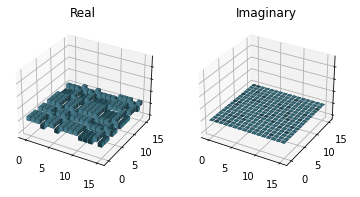

lin4 compiled, with noise


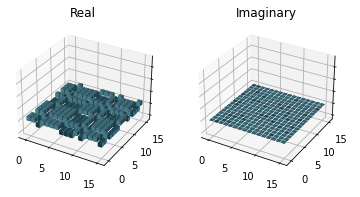

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [26]:
""" Noise simulation (basic example). Let's consider a 4 qubit linear graph state example with noise """

import src.noise.noise_models as nm
import numpy as np
from benchmarks.circuits import linear_cluster_4qubit_circuit

lin4_circuit, lin4_expected = linear_cluster_4qubit_circuit()
lin4_expected = DensityMatrix(lin4_expected['dm'])

# Noise model pulled from our tests--more on this later
noise_model_mapping = {
    "Identity": nm.OneQubitGateReplacement(
        dmf.parameterized_one_qubit_unitary(np.pi / 180, 0, 0)
    ),
    "SigmaX": nm.DepolarizingNoise(0.01),
    "CNOT": nm.DepolarizingNoise(0.01),
}

# We can pass this noise model directly into the solver usually, but we will have to manually add it here for the demo
for op in lin4_circuit.sequence():
    op.noise = noise_model_mapping.get(op.__class__.__name__, nm.NoNoise())  # no noise if unspecified


# Compile, with noise this time
output_state = compiler.compile(lin4_circuit)

# trace out the emitter qubit
new_dm = dmf.partial_trace(
    output_state.data,
    keep=[0, 1, 2, 3],
    dims=5 * [2]
)

output_state.data = new_dm

# Compare expected and retrieved results

print('lin4 expected')
lin4_expected.draw()

print('lin4 compiled, with noise')
output_state.draw()

Notice how the noisy version of the state looks somewhat different! You can play with the noise initialization dictionary, and you'll see that the largest noise effects seem to come from the CNOT gate.

In [41]:
"""
Effects of measurement determinism

We will manually show the effects here, though normally this is built into the compiler
"""

# Let's build a very simple circuit where (with a proper probabilistic treatment) we expect P(0) = P(1) = 1/2
from src.circuit import CircuitDAG
import src.ops as ops

circuit = CircuitDAG()
circuit.add(ops.Hadamard(register=0, reg_type='e'))

compiler = DensityMatrixCompiler()

def check_measurement_result_ratio(determinism):
    n_retries = 100
    measurement1_count = 0
    for i in range(n_retries):
        output_state = compiler.compile(circuit)

        # This part happens inside the compiler if we add a MeasurementZ operation. We execute the code manually here
        # such that we can examine the result easily
        projectors = dmf.projectors_zbasis(
            1, # number of qubits
            0  # index of the qubit to measure, in the density matrix
        )

        outcome = output_state.apply_measurement(
            projectors, measurement_determinism=determinism
        )
        measurement1_count += outcome

    print(f'measurement 1 ratio, determinism = {determinism}: {measurement1_count / n_retries}')
    
# Look at probabilistic results
compiler.measurement_determinism = 'probabilistic'
check_measurement_result_ratio(compiler.measurement_determinism)


# Look at measurement_determinism == 1 results
compiler.measurement_determinism = 1
check_measurement_result_ratio(compiler.measurement_determinism)

# Look at measurement_determinism == 0 results
compiler.measurement_determinism = 0
check_measurement_result_ratio(compiler.measurement_determinism)

measurement 1 ratio, determinism = probabilistic: 0.48
measurement 1 ratio, determinism = 1: 1.0
measurement 1 ratio, determinism = 0: 0.0


# TODO: inner working explanations (after stabilizer is in)